# Unsupervised Learning (5) - Clustering, Dimensionality Reduction
## Machine Learning Lectures by the ESA Data Analytics Team for Operations (DATO)
#### [José Martínez Heras](https://www.linkedin.com/in/josemartinezheras/)

## Resouces
This notebook is best followed when watched along to its corresponding [clustering Dow Jones stocks **video**](https://dlmultimedia.esa.int/download/public/videos/2048/03/007/4803_007_AR_EN.mp4)

The tutorial about Linear Regression can be found in the [2018-MachineLearning-Lectures-ESA **GitHub**](https://github.com/jmartinezheras/2018-MachineLearning-Lectures-ESA)

## Goal of today's project
Learn about stock data and use clustering to group together the stocks with similar behaviour

In particular, we will look at the stocks that are part of the Dow Jones Industrial Index
(all stocks from Standards & Poors 500 are available if you want to further experiment)

## Import Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,4.5) # Make the default figures a bit bigger

import numpy as np
import random

#Let's make this notebook reproducible 
np.random.seed(42)
random.seed(42)

import pandas as pd
from wikitables import import_tables #to download tables from the Wikipedia

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


## Data
For this analysis, we use 3 sources:

* Data over the last 5 years from the Standard & Poors 500 index components downloaded from https://www.kaggle.com/camnugent/sandp500/data (more information on https://www.kaggle.com/camnugent/sandp500 )
* Metadata about the S&P 500 index components stocks (mainly to know the company name from the symbol) from https://en.wikipedia.org/wiki/List_of_S%26P_500_companies
* List of companies that are part of the Dow Jones Industrial Average index from https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average

### Standars & Poors 500 Data Description

Note: this description has been taken from https://www.kaggle.com/camnugent/sandp500

The data is presented in a couple of formats to suit different individual's needs or computational limitations. I have included files containing 5 years of stock data (in the all_stocks_5yr.csv and corresponding folder).

The folder individual_stocks_5yr contains files of data for individual stocks, labelled by their stock ticker name. The all_stocks_5yr.csv contains the same data, presented in a merged .csv file. Depending on the intended use (graphing, modelling etc.) the user may prefer one of these given formats.

All the files have the following columns: Date - in format: yy-mm-dd

* Open - price of the stock at market open (this is NYSE data so all in USD)
* High - Highest price reached in the day
* Low Close - Lowest price reached in the day
* Volume - Number of shares traded
* Name - the stock's ticker name

In [2]:
stocks_data = pd.read_csv('data/all_stocks_5yr.csv.zip')
stocks_data = stocks_data.rename(columns={'Name':'symbol'})
stocks_data['date'] = pd.to_datetime(stocks_data['date'])
stocks_data.head()

,date,open,high,low,close,volume,symbol
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


## List of the S&P 500 companies 
Download the table from wikipedia [ https://en.wikipedia.org/wiki/List_of_S%26P_500_companies ] and store it for later use

In [3]:
try:
    companies = pd.read_csv('data/companies.csv')
    print('companies metadata loaded from cached file')
except FileNotFoundError:
    print('getting companies metadata from wikipedia ...')
    tables = import_tables('list of S&P 500 companies')
    companies = pd.read_json(tables[0].json())
    for c in companies.columns:
        if type(companies[c].iloc[0]) is str:
            companies[c] = companies[c].str.strip().str.replace('\t','')
    companies.columns = ['address', 'CIK', 'date first added', 'sector', 'sub-industry', 'filings', 'security', 'symbol']
    companies = companies[['symbol', 'security', 'sector', 'sub-industry']]
    companies = companies.sort_values('symbol')
    companies = companies.set_index('symbol')
    companies.to_csv('data/companies.csv', index_label=False)
    print('caching it to data/companies.csv file')

companies metadata loaded from cached file


In [4]:
companies.head()

,security,sector,sub-industry
A,Agilent Technologies Inc,Health Care,Health Care Equipment
AAL,American Airlines Group,Industrials,Airlines
AAP,Advance Auto Parts,Consumer Discretionary,Automotive Retail
AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals"
ABBV,AbbVie Inc.,Health Care,Pharmaceuticals


## List of the Dow Jones companies 
Download the table from wikipedia [https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average] and store it for later use

In [5]:
try:
    dow = pd.read_csv('data/dow.csv')
    print('dow metadata loaded from cached file')
except FileNotFoundError:
    print('getting dow jones companies metadata from wikipedia ...')
    tables = import_tables('Dow_Jones_Industrial_Average')
    dow = pd.read_json(tables[0].json())
    for c in dow.columns:
        if type(dow[c].iloc[0]) is str:
            dow[c] = dow[c].str.strip().str.replace('\t','')
    dow = dow[['Symbol', 'Company']]
    dow.columns = [c.lower() for c in dow.columns]
    dow = dow.sort_values('symbol')
    dow = dow.set_index('symbol')
    dow.to_csv('data/dow.csv', index_label=False)
    print('caching it to data/dow.csv file')

dow metadata loaded from cached file


In [6]:
dow.head()

,company
AAPL,Apple
AXP,American Express
BA,Boeing
CAT,Caterpillar
CSCO,Cisco Systems


## Data Preparation
For this analysis, let't just consider the date, the price at close and the symbol

In [7]:
stocks_data = stocks_data[['date', 'close', 'symbol']]
stocks_data.head()

,date,close,symbol
0,2013-02-08,14.75,AAL
1,2013-02-11,14.46,AAL
2,2013-02-12,14.27,AAL
3,2013-02-13,14.66,AAL
4,2013-02-14,13.99,AAL


Use pivot tables to have a different stock at every column

drop the stocks that were not part of the S&P 500 for the whole period that this dataset covers

In [8]:
stocks = stocks_data.pivot(index='date', columns='symbol', values='close')
stocks = stocks.dropna(axis=1)
stocks.head()

symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-02-08,45.08,14.75,78.90,67.8542,36.25,46.89,34.41,73.31,39.12,45.70,...,28.24,37.51,88.61,42.87,31.84,27.09,65.30,75.85,24.14,33.05
2013-02-11,44.60,14.46,78.39,68.5614,35.85,46.76,34.26,73.07,38.64,46.08,...,28.31,37.46,88.28,42.84,31.96,27.46,64.55,75.65,24.21,33.26
2013-02-12,44.62,14.27,78.60,66.8428,35.42,46.96,34.30,73.37,38.89,46.27,...,28.41,37.58,88.46,42.87,31.84,27.95,64.75,75.44,24.49,33.74
2013-02-13,44.75,14.66,78.97,66.7156,35.27,46.64,34.46,73.56,38.81,46.26,...,28.42,37.80,88.67,43.08,32.00,28.26,64.41,76.00,24.74,33.55
2013-02-14,44.58,13.99,78.84,66.6556,36.57,46.77,34.70,73.13,38.61,46.54,...,28.22,38.44,88.52,42.91,32.12,28.47,63.89,76.34,24.63,33.27


### Resample data
You may decide to resample data. You may try:
* W for weekly data
* M for monthly data
* Q for quarter 
* A for year

In [9]:
stocks = stocks.resample('W').last()
stocks.head()

symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-02-10,45.08,14.75,78.90,67.8542,36.25,46.89,34.41,73.31,39.120,45.700,...,28.24,37.51,88.61,42.87,31.84,27.09,65.30,75.85,24.14,33.05
2013-02-17,42.25,14.50,79.00,65.7371,37.58,46.60,35.08,74.16,38.635,46.175,...,28.67,38.12,88.36,42.80,31.88,28.28,63.99,75.90,24.34,33.98
2013-02-24,41.80,13.57,79.21,64.4014,38.46,46.95,34.55,74.80,38.550,45.520,...,28.99,37.96,89.20,41.78,32.48,27.79,65.45,74.14,24.04,32.59
2013-03-03,41.93,13.61,76.37,61.4957,37.81,47.98,33.60,74.82,39.830,45.230,...,28.82,36.65,89.43,41.16,32.60,27.49,65.21,74.99,24.04,34.60
2013-03-10,43.03,14.92,76.84,61.6742,37.34,48.48,34.68,78.35,41.500,46.050,...,29.66,38.37,88.97,42.74,34.84,28.43,67.72,75.40,25.30,34.09


## Exploratory Data Analysis (EDA)

In [10]:
def get_name(symbol):
    name = symbol
    try:
        name = companies.loc[symbol]['security']
    except KeyError:
        pass
    return name

def plot_stock(symbol, stocks=stocks):
    name = get_name(symbol)
    stocks[symbol].plot(title=name, label=name, alpha=0.9);

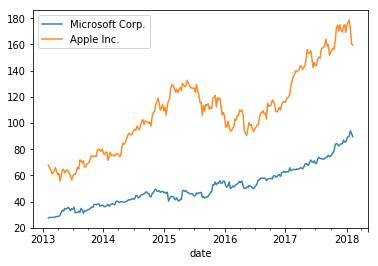

In [11]:
plot_stock('MSFT')
plot_stock('AAPL')
plt.title('')
plt.legend();

### Compute returns so that we can compare stocks
We will compute the return from the first day of the purchase. So the return of any given day is how much it would be earned (or lost) - in percentage - if the stock would be sold at this day (transaction are costs not considered)

In [12]:
start = stocks.iloc[0]
returns = (stocks - start) / start

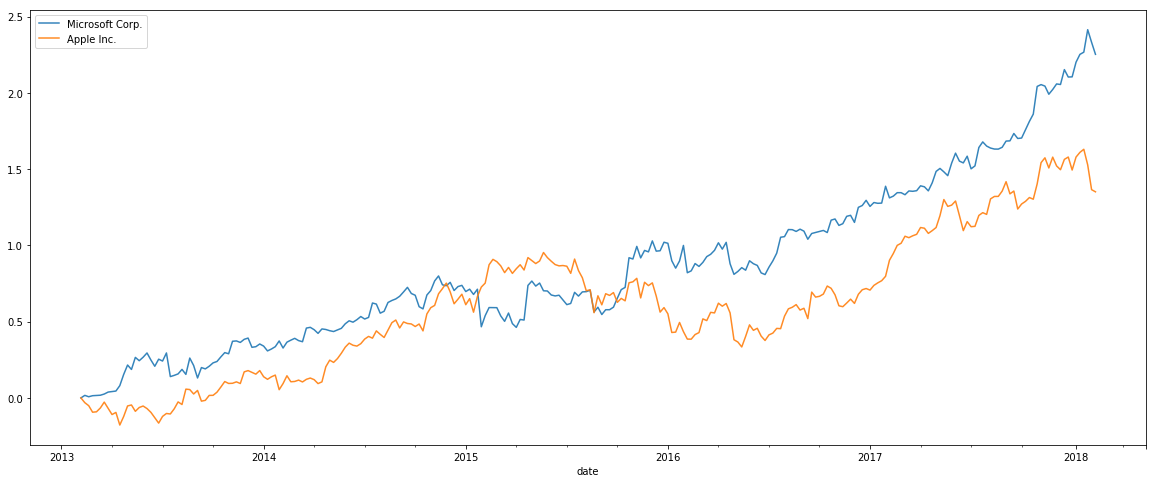

In [13]:
plt.figure(figsize = (20,8))
plot_stock('MSFT', stocks=returns)
plot_stock('AAPL', stocks=returns)
plt.title('')
plt.legend();

#### Which were the best and worst performing stocks in the last 5 years?

In [14]:
best = returns.iloc[-1].sort_values(ascending=False).head()
worst = returns.iloc[-1].sort_values().head()

In [15]:
print('Best performing stocks')
names = pd.DataFrame({'name':[get_name(symbol) for symbol in best.index.tolist()]}, index = best.index)
best = pd.concat((best, names), axis=1)
best

Best performing stocks


,2018-02-11 00:00:00,name
symbol,,
NVDA,17.496362,Nvidia Corporation
NFLX,9.233321,Netflix Inc.
ALGN,6.159487,Align Technology
EA,6.084053,Electronic Arts
STZ,5.723705,Constellation Brands


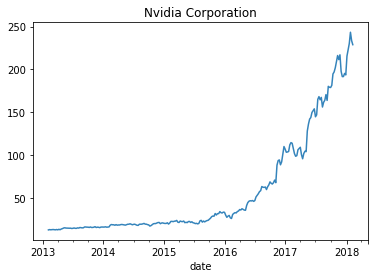

In [16]:
plot_stock('NVDA')

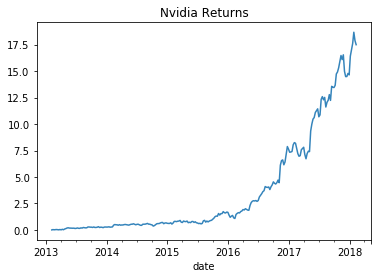

In [17]:
plot_stock('NVDA', stocks=returns)
plt.title('Nvidia Returns');

In [18]:
print('Worst performing stocks')
names = pd.DataFrame({'name':[get_name(symbol) for symbol in worst.index.tolist()]}, index = worst.index)
worst = pd.concat((worst, names), axis=1)
worst

Worst performing stocks


,2018-02-11 00:00:00,name
symbol,,
CHK,-0.857143,CHK
RRC,-0.818157,Range Resources Corp.
DISCA,-0.676508,Discovery Inc. Class A
DISCK,-0.660217,Discovery Inc. Class C
MOS,-0.588762,The Mosaic Company


In [19]:
[get_name(symbol) + ' (' + symbol +')' for symbol in worst.index.tolist()] 

['CHK (CHK)',
 'Range Resources Corp. (RRC)',
 'Discovery Inc. Class A (DISCA)',
 'Discovery Inc. Class C (DISCK)',
 'The Mosaic Company (MOS)']

### Let's now focus on the Dow Jones stocks

In [20]:
dow_stocks = [s for s in dow.index if s in stocks.columns]
dow_returns = returns[dow_stocks]

In [21]:
print(dow_stocks)

['AAPL', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'DIS', 'GE', 'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PFE', 'PG', 'TRV', 'UNH', 'UTX', 'V', 'VZ', 'WMT', 'XOM']


In [22]:
best_dow = dow_returns.iloc[-1].sort_values(ascending=False).head()
worst_dow = dow_returns.iloc[-1].sort_values().head()
print('Best performing Dow Jones stocks')
names = pd.DataFrame({'name':[get_name(symbol) for symbol in best_dow.index.tolist()]}, index = best_dow.index)
best_dow = pd.concat((best_dow, names), axis=1)
best_dow

Best performing Dow Jones stocks


,2018-02-11 00:00:00,name
symbol,,
BA,3.547022,Boeing Company
UNH,2.910980,United Health Group Inc.
MSFT,2.252632,Microsoft Corp.
V,2.032953,Visa Inc.
HD,1.854649,Home Depot


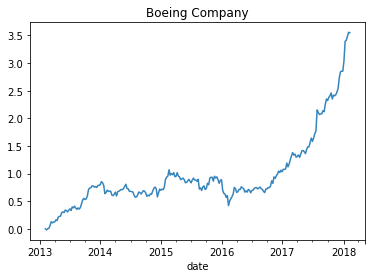

In [23]:
plot_stock('BA', stocks=returns);

In [24]:
print('Worst performing Dow Jones stocks')
names = pd.DataFrame({'name':[get_name(symbol) for symbol in worst_dow.index.tolist()]}, index = worst_dow.index)
worst_dow = pd.concat((worst_dow, names), axis=1)
worst_dow

Worst performing Dow Jones stocks


,2018-02-11 00:00:00,name
symbol,,
GE,-0.322222,General Electric
IBM,-0.237158,International Business Machines
XOM,-0.131701,Exxon Mobil Corp.
CVX,-0.003027,Chevron Corp.
PG,0.080396,Procter & Gamble


## Clustering

In [25]:
print('Number of dimensions: ', len(dow_returns))

Number of dimensions:  262


In [26]:
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(dow_returns.T);

clusters = {}
for l in np.unique(kmeans.labels_):
    clusters[l] = []

for i,l in enumerate(kmeans.predict(dow_returns.T)):
    clusters[l].append(dow_returns.columns[i])
    
for c in sorted(clusters):
    print('Cluster ' + str(c) + ': ', end='')
    for symbol in clusters[c]:
        print(get_name(symbol) + ' (' + symbol + ')', end=' ### ')
    print()
    print()

Cluster 0: American Express Co (AXP) ### General Electric (GE) ### Goldman Sachs Group (GS) ### Coca-Cola Company (The) (KO) ### McDonald's Corp. (MCD) ### Pfizer Inc. (PFE) ### Procter & Gamble (PG) ### United Technologies (UTX) ### Verizon Communications (VZ) ### Wal-Mart Stores (WMT) ### 

Cluster 1: Apple Inc. (AAPL) ### 3M Company (MMM) ### 

Cluster 2: United Health Group Inc. (UNH) ### 

Cluster 3: Caterpillar Inc. (CAT) ### Chevron Corp. (CVX) ### International Business Machines (IBM) ### Exxon Mobil Corp. (XOM) ### 

Cluster 4: Home Depot (HD) ### Microsoft Corp. (MSFT) ### Visa Inc. (V) ### 

Cluster 5: Cisco Systems (CSCO) ### Intel Corp. (INTC) ### Johnson & Johnson (JNJ) ### JPMorgan Chase & Co. (JPM) ### Merck & Co. (MRK) ### The Travelers Companies Inc. (TRV) ### 

Cluster 6: The Walt Disney Company (DIS) ### Nike (NKE) ### 

Cluster 7: Boeing Company (BA) ### 



In [27]:
#inertias = []
#for k in range(2, 15):
#    kmeans = KMeans(n_clusters=k)
#    kmeans.fit(dow_returns.T)
#    inertias.append(kmeans.inertia_)
#plt.plot(range(2,15), inertias)
#plt.title('Inertia with dow_returns components');

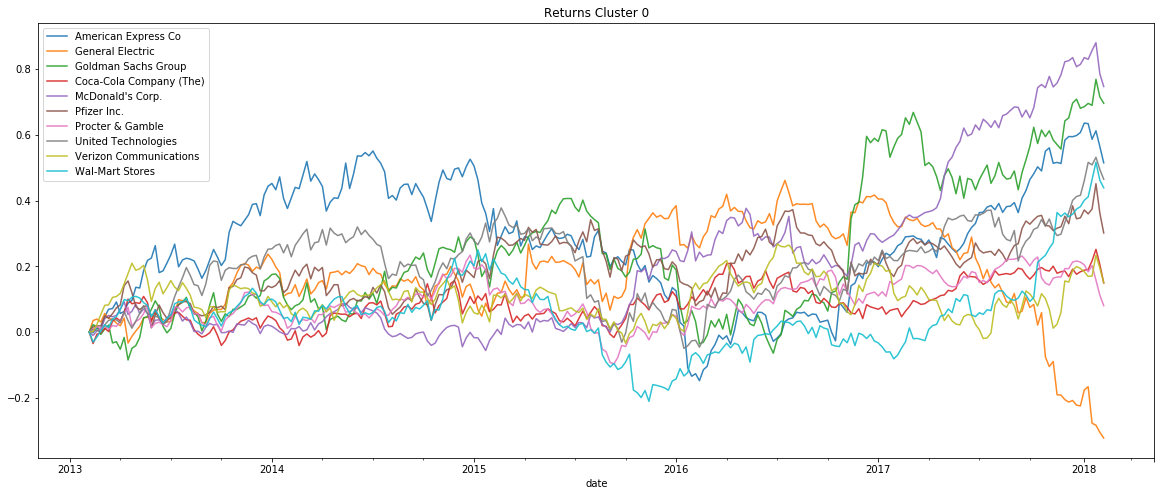

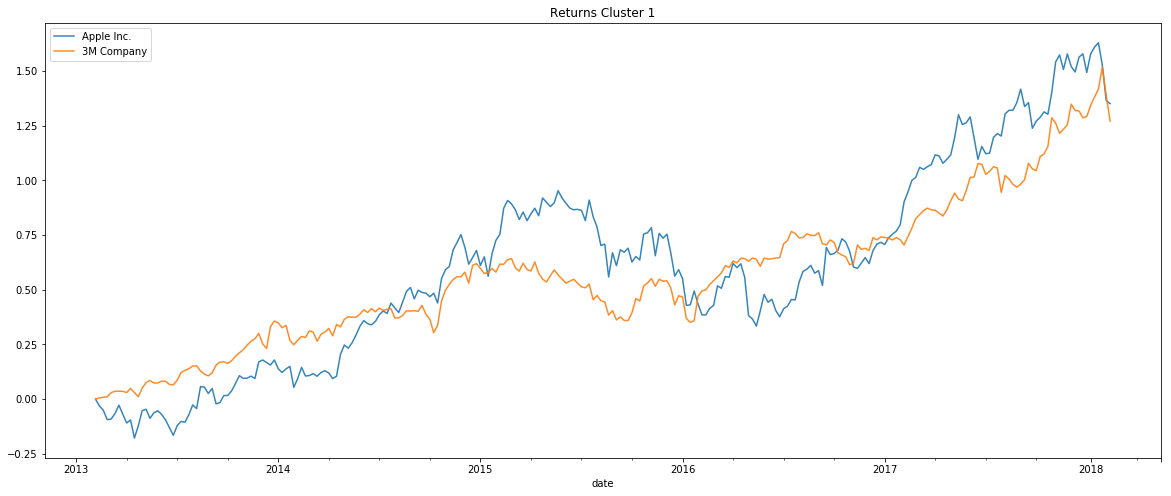

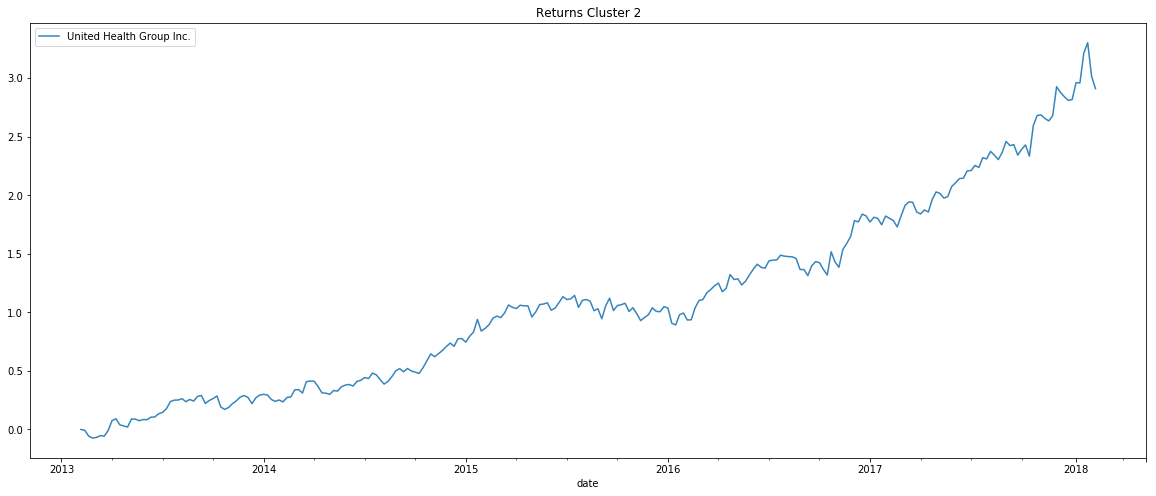

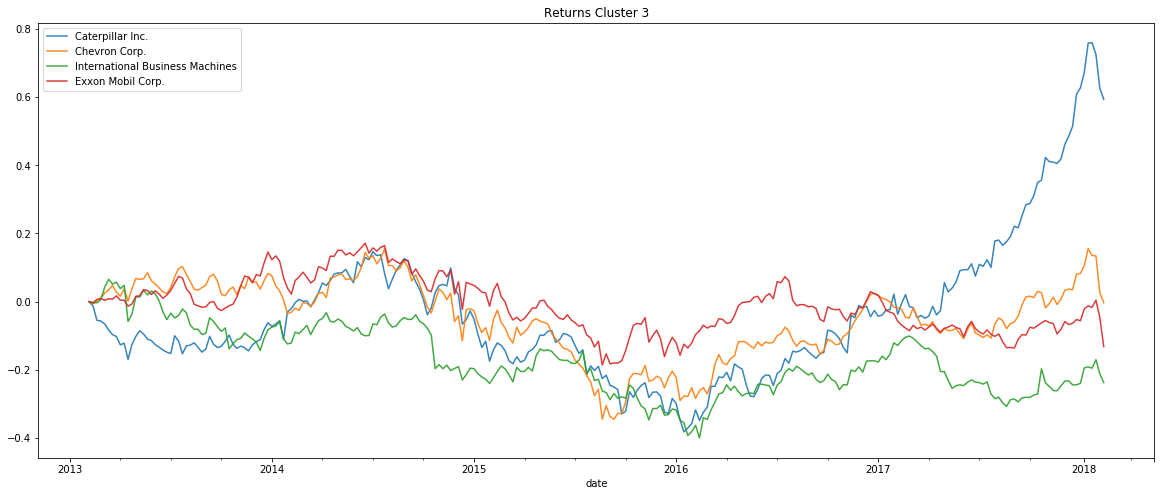

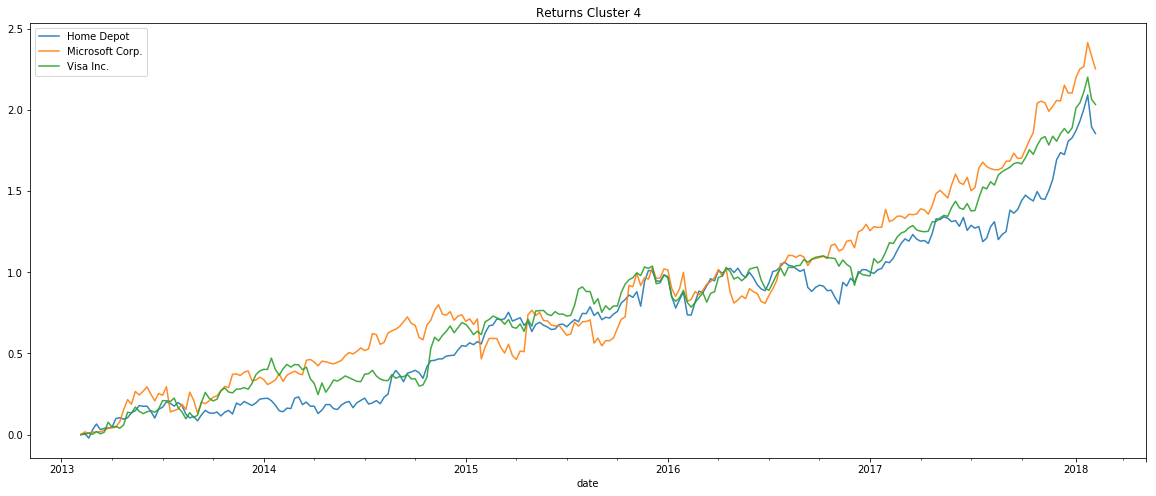

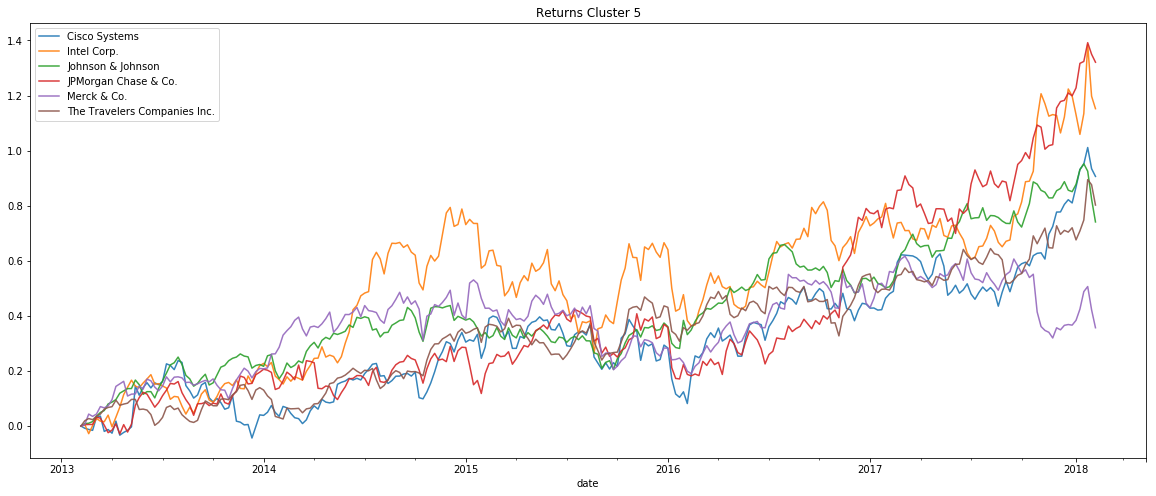

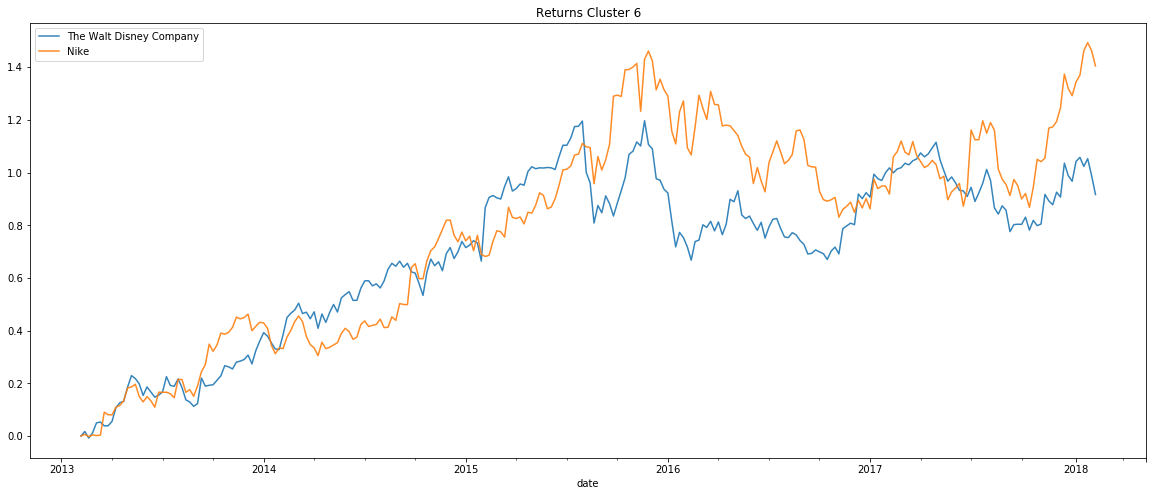

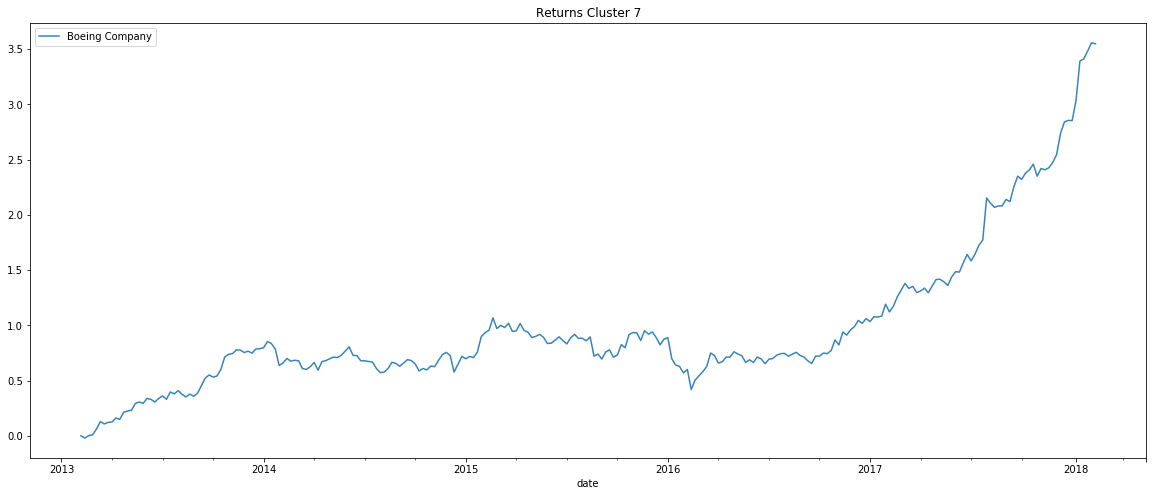

In [28]:
for c in sorted(clusters):
    plt.figure(figsize = (20,8))
    for symbol in clusters[c]:
        plot_stock(symbol, stocks=dow_returns)
    plt.title('Returns Cluster ' + str(c))
    plt.legend()
    plt.show()

## Principal Components Analysis
Let's keep al least 95% of the variance

In [29]:
pca = PCA(n_components=.95, random_state=1)
components = pca.fit_transform(dow_returns.T)
print('Number of PCA components', components.shape[1])
print('PCA explained variance ratio:', pca.explained_variance_ratio_)
print('PCA total explained variance: ', np.sum(pca.explained_variance_ratio_))


Number of PCA components 3
PCA explained variance ratio: [0.88663771 0.05641927 0.02300511]
PCA total explained variance:  0.9660620949177288


### Let's see how well can represent the signal
We are going to use the function PCA.inverse_transform to go from the PCA components to the returns
Then we are going to plot the original returns and the recovered returns from the PCA componets to get a visual intuition

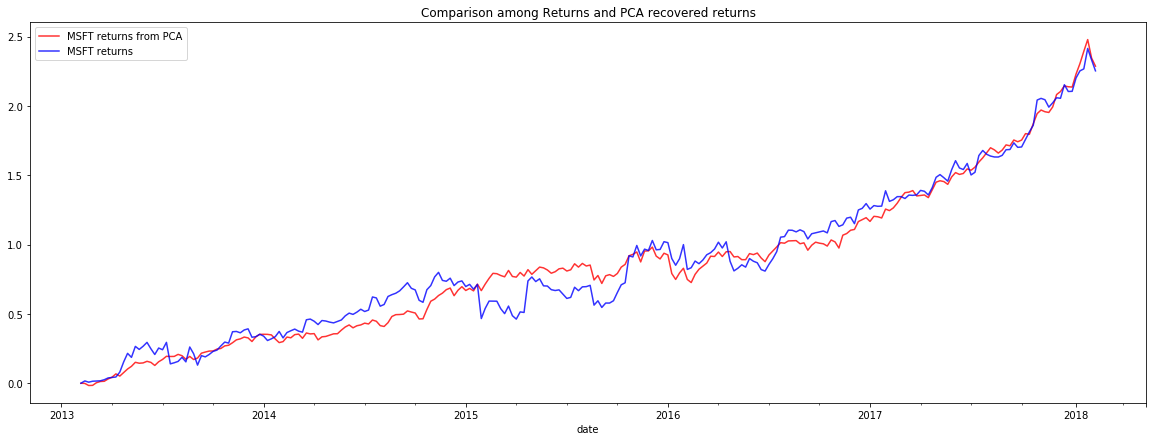

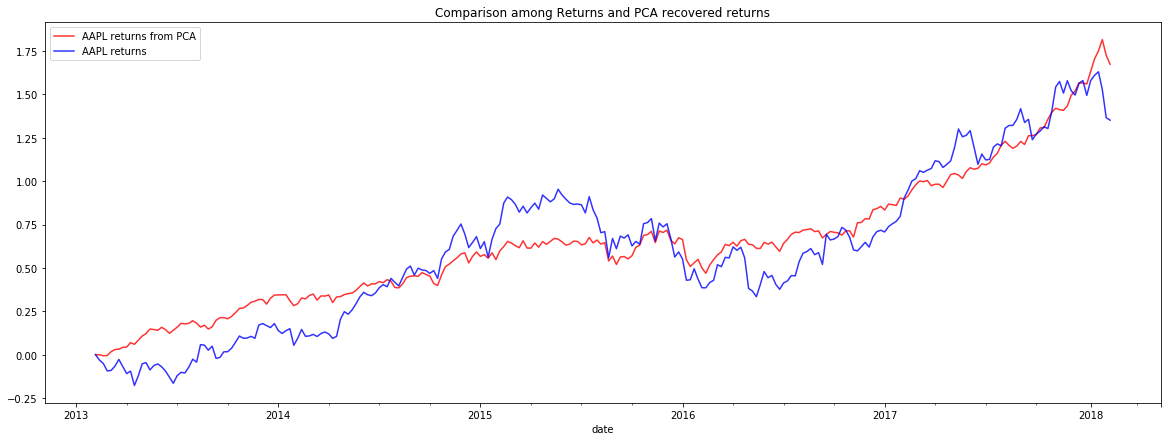

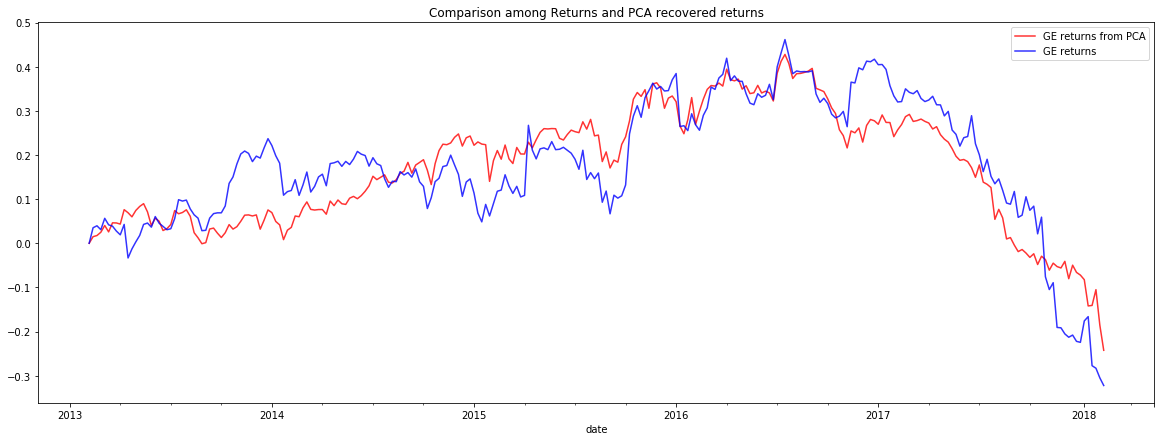

In [30]:
for stock in ['MSFT', 'AAPL', 'GE']:
    pos_stock = dow_returns.columns.tolist().index(stock)
    stock_from_pca = pca.inverse_transform(components[pos_stock,:])
    stock_from_pca = pd.Series(stock_from_pca, name=stock, index=dow_returns.index)
    plt.figure(figsize=(20,7))
    stock_from_pca.plot(label = stock + ' returns from PCA', color='red', alpha=0.8)
    dow_returns[stock].plot(label = stock + ' returns', color='blue', alpha=0.8)
    plt.title('Comparison among Returns and PCA recovered returns')
    plt.legend()
    plt.show();

### Let's visualize the first 2 components 

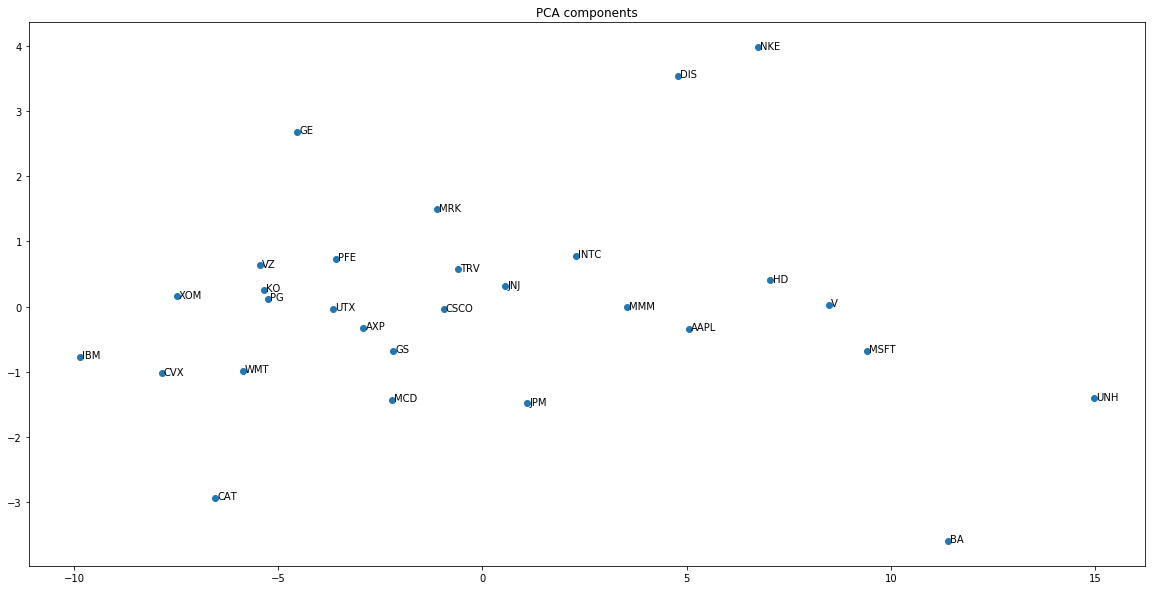

In [31]:
plt.figure(figsize=(20,10))
plt.scatter(components[:,0], components[:,1])
for i in range(components.shape[0]):
    plt.text(x=components[i,0]+0.05, y=components[i,1]-0.025, s=dow_returns.columns[i])
plt.title('PCA components');

### Let's use the log return after 5 years to color the data to gain some insights of what the PCA is doing

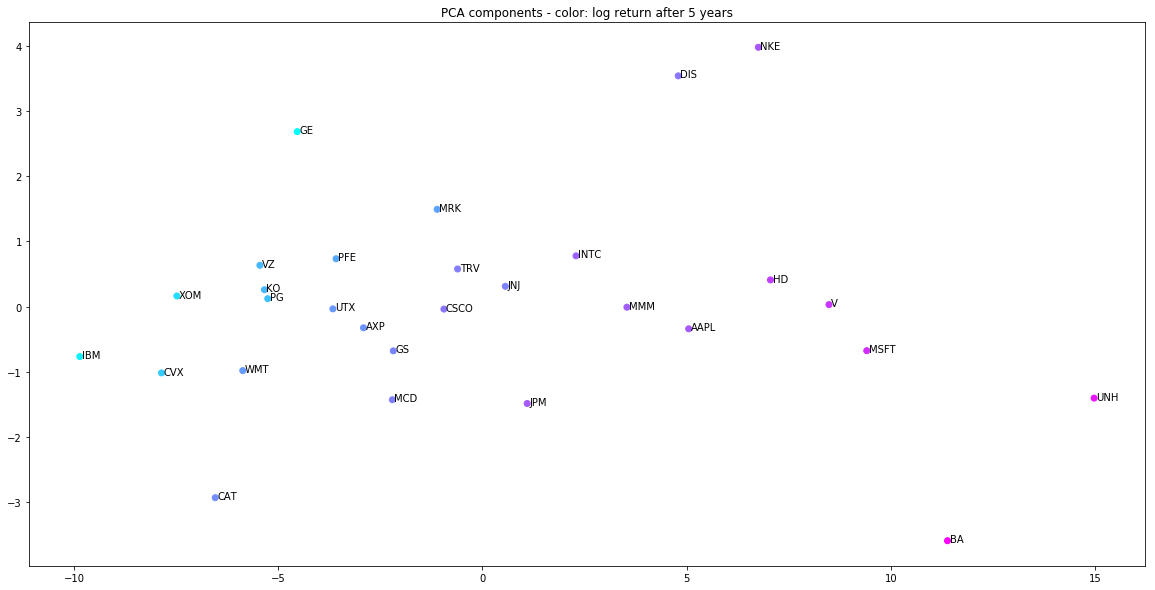

In [32]:
plt.figure(figsize=(20,10))
plt.scatter(components[:,0], components[:,1],  c = dow_returns.iloc[-1].T.apply(np.log1p), cmap='cool')
for i in range(components.shape[0]):
    symbol = dow_returns.columns[i]
    plt.text(x=components[i,0]+0.05, y=components[i,1]-0.025, s=symbol,)
plt.title('PCA components - color: log return after 5 years');

### Clustering with PCA components

In [33]:
print('Number of dimensions for clustering with PCA: ', len(components.T))

Number of dimensions for clustering with PCA:  3


In [34]:
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(components);

clusters = {}
for l in np.unique(kmeans.labels_):
    clusters[l] = []

for i,l in enumerate(kmeans.predict(components)):
    clusters[l].append(dow_returns.columns[i])
    
for c in clusters:
    print('Cluster ' + str(c) + ': ', end='')
    for symbol in clusters[c]:
        print(get_name(symbol) + ' (' + symbol + ')', end=' ### ')
    print()
    print()

Cluster 0: American Express Co (AXP) ### General Electric (GE) ### Coca-Cola Company (The) (KO) ### Pfizer Inc. (PFE) ### Procter & Gamble (PG) ### United Technologies (UTX) ### Verizon Communications (VZ) ### 

Cluster 1: Apple Inc. (AAPL) ### Intel Corp. (INTC) ### 3M Company (MMM) ### 

Cluster 2: Boeing Company (BA) ### 

Cluster 3: Home Depot (HD) ### Microsoft Corp. (MSFT) ### Visa Inc. (V) ### 

Cluster 4: Caterpillar Inc. (CAT) ### Chevron Corp. (CVX) ### International Business Machines (IBM) ### Wal-Mart Stores (WMT) ### Exxon Mobil Corp. (XOM) ### 

Cluster 5: Cisco Systems (CSCO) ### Goldman Sachs Group (GS) ### Johnson & Johnson (JNJ) ### JPMorgan Chase & Co. (JPM) ### McDonald's Corp. (MCD) ### Merck & Co. (MRK) ### The Travelers Companies Inc. (TRV) ### 

Cluster 6: The Walt Disney Company (DIS) ### Nike (NKE) ### 

Cluster 7: United Health Group Inc. (UNH) ### 



In [35]:
#inertias = []
#for k in range(2, 15):
#    kmeans = KMeans(n_clusters=k, random_state=42)
#    kmeans.fit(components)
#    inertias.append(kmeans.inertia_)
#plt.plot(range(2,15), inertias)
#plt.title('Inertia with PCA components');


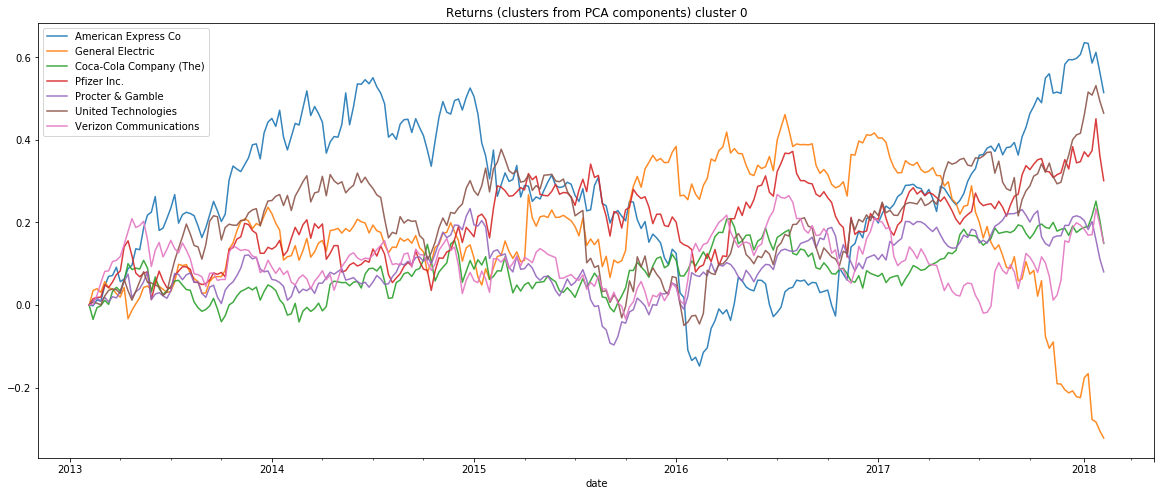

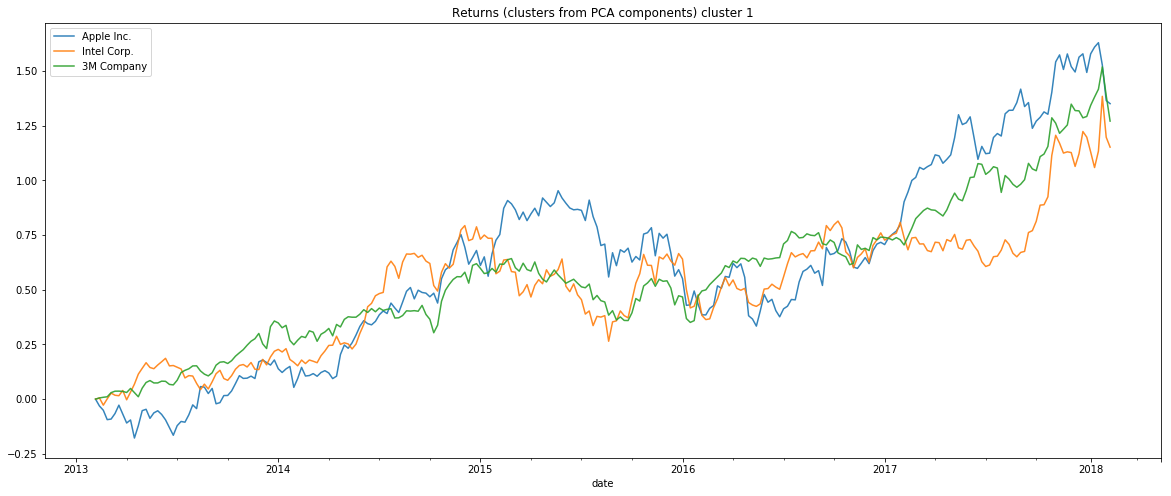

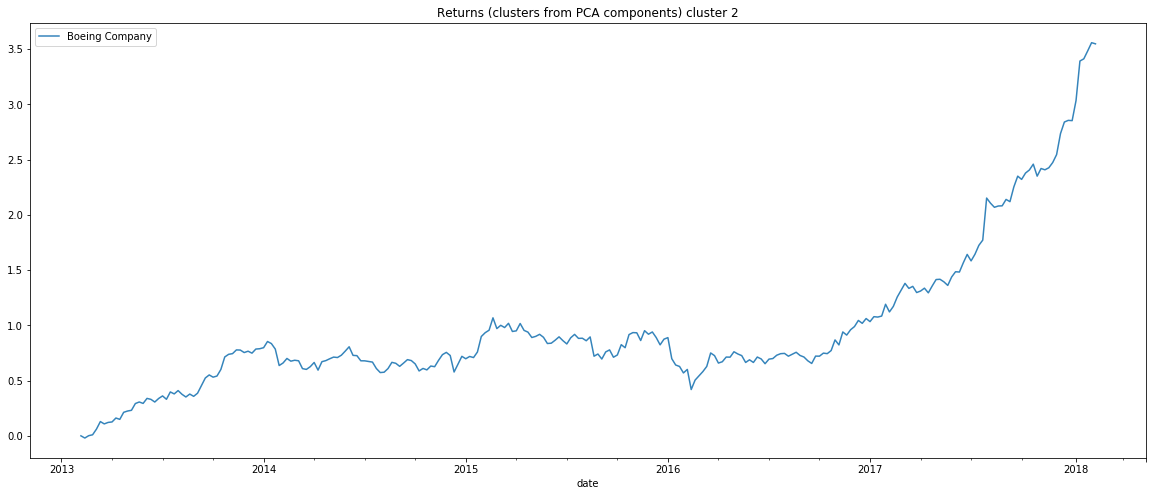

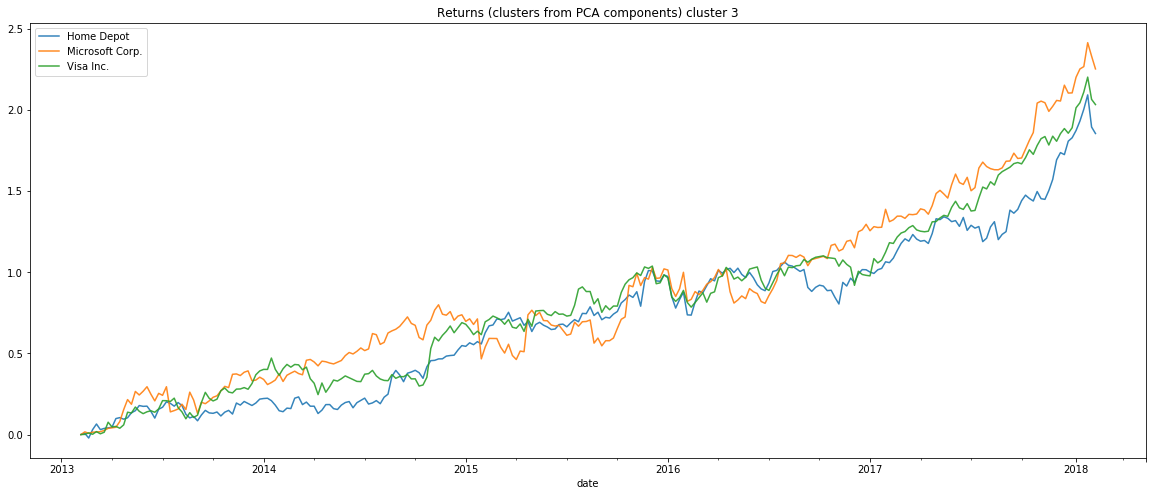

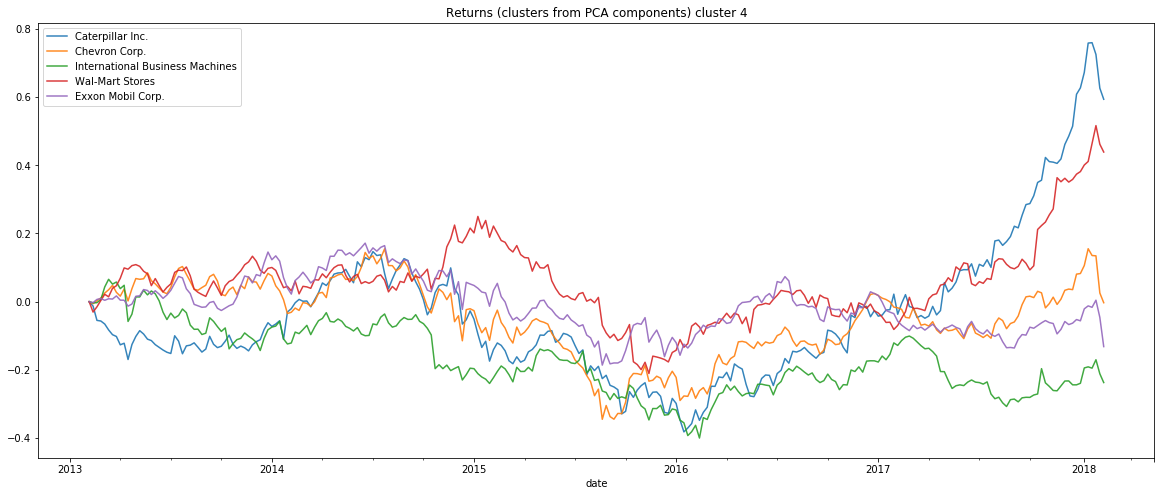

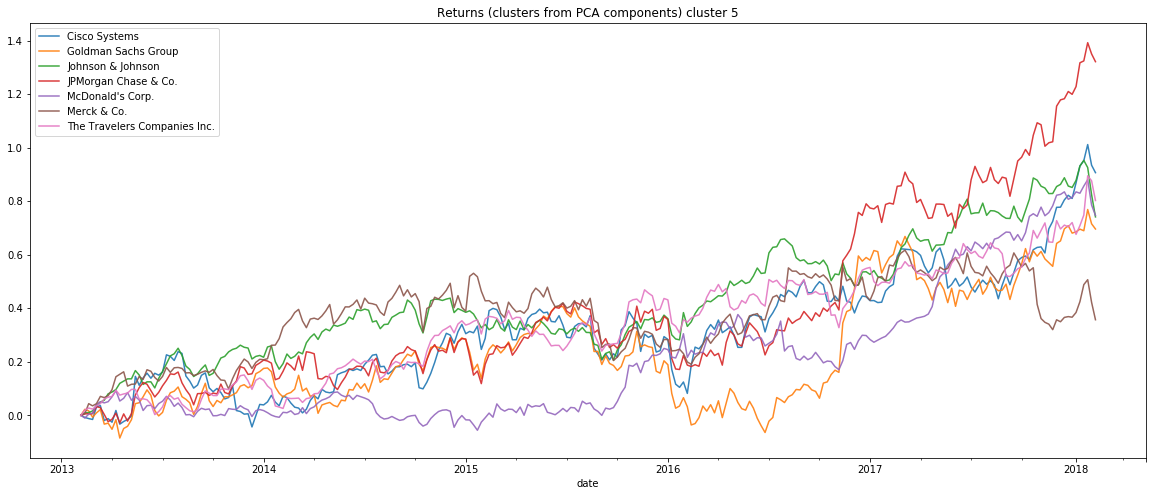

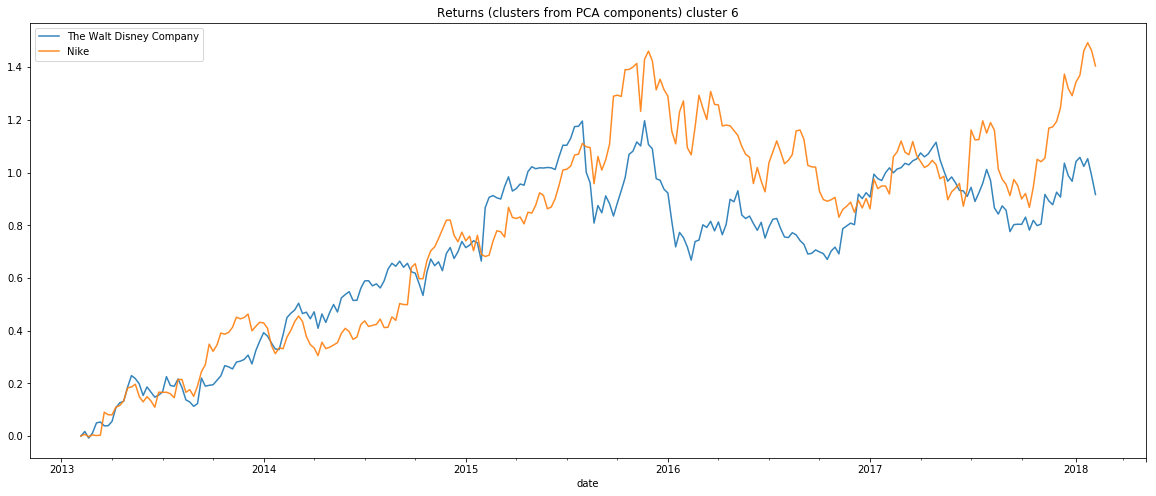

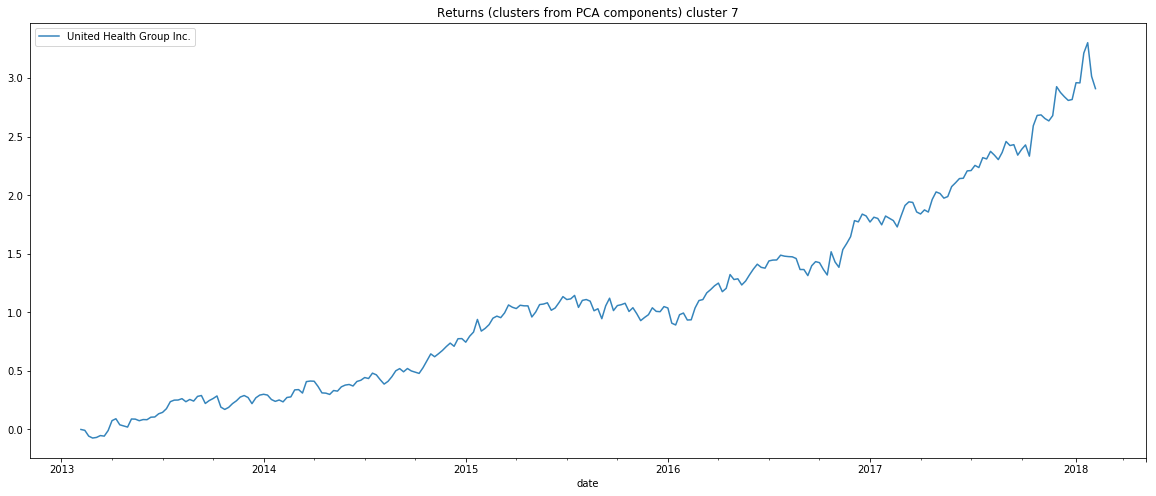

In [36]:
for c in sorted(clusters):
    plt.figure(figsize = (20,8))
    for symbol in clusters[c]:
        plot_stock(symbol, stocks=dow_returns)
    plt.title('Returns (clusters from PCA components) cluster ' + str(c))
    plt.legend()
    plt.show()

## Mid-Point & Final values 
Now, let's attempt to sumarize the behaviour of stocks in the Dow Jones by just 2 values:
* the return in the half of the 5 year period (e.g. return after 2.5 years)
* the return at the end of the 5 year period (e.g. return after 5 years)

In [37]:
mid_point = len(dow_returns) // 2
mid_final = dow_returns.iloc[[mid_point, -1]]
mid_final

symbol,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GE,GS,HD,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2015-08-16,0.708958,0.309223,0.895115,-0.189572,0.371928,-0.256399,0.960483,0.159111,0.332586,0.787047,...,1.094889,0.313988,-0.001716,0.365838,1.095947,0.095571,0.881369,0.070800,0.012591,-0.115675
2018-02-11,1.351218,0.514725,3.547022,0.593598,0.906427,-0.003027,0.916575,-0.322222,0.695910,1.854649,...,1.404470,0.301339,0.080396,0.802435,2.910980,0.464868,2.032953,0.150169,0.438864,-0.131701


### 2D Plot of the Dow Jones stocks in the mid_final representation

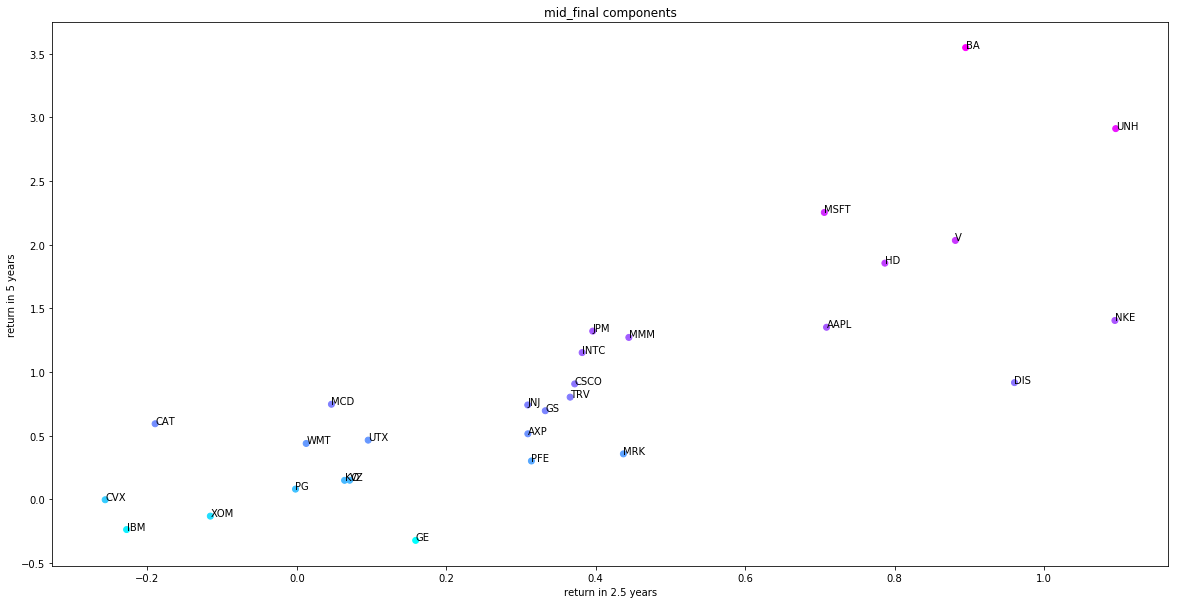

In [38]:
plt.figure(figsize=(20,10))
plt.scatter(mid_final.T.iloc[:,0], mid_final.T.iloc[:,1], c=mid_final.iloc[-1].T.apply(np.log1p), cmap='cool')
for c in mid_final.columns:
    plt.text(x=mid_final[c].iloc[0], y=mid_final[c].iloc[1], s=c)
plt.xlabel('return in 2.5 years')
plt.ylabel('return in 5 years')
plt.title('mid_final components');

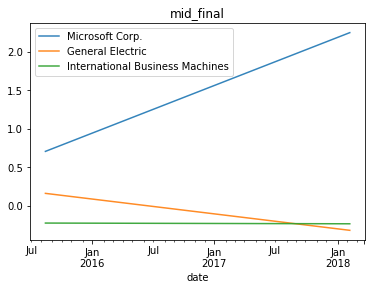

In [39]:
for stock in ['MSFT', 'GE', 'IBM']:
    plot_stock(stock, stocks=mid_final)
plt.title('mid_final')
plt.legend();

### Clustering on the mid_final representation

In [40]:
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(mid_final.T);

clusters = {}
for l in np.unique(kmeans.labels_):
    clusters[l] = []

for i,l in enumerate(kmeans.predict(mid_final.T)):
    clusters[l].append(mid_final.columns[i])
    
for c in clusters:
    print('Cluster ' + str(c) + ': ', end='')
    for symbol in clusters[c]:
        print(get_name(symbol) + ' (' + symbol + ')', end=' ### ')
    print()
    print()

Cluster 0: The Walt Disney Company (DIS) ### Nike (NKE) ### 

Cluster 1: Home Depot (HD) ### Microsoft Corp. (MSFT) ### Visa Inc. (V) ### 

Cluster 2: Caterpillar Inc. (CAT) ### McDonald's Corp. (MCD) ### United Technologies (UTX) ### Wal-Mart Stores (WMT) ### 

Cluster 3: Boeing Company (BA) ### United Health Group Inc. (UNH) ### 

Cluster 4: Chevron Corp. (CVX) ### General Electric (GE) ### International Business Machines (IBM) ### Coca-Cola Company (The) (KO) ### Procter & Gamble (PG) ### Verizon Communications (VZ) ### Exxon Mobil Corp. (XOM) ### 

Cluster 5: Apple Inc. (AAPL) ### Intel Corp. (INTC) ### JPMorgan Chase & Co. (JPM) ### 3M Company (MMM) ### 

Cluster 6: American Express Co (AXP) ### Merck & Co. (MRK) ### Pfizer Inc. (PFE) ### 

Cluster 7: Cisco Systems (CSCO) ### Goldman Sachs Group (GS) ### Johnson & Johnson (JNJ) ### The Travelers Companies Inc. (TRV) ### 



In [41]:
#inertias = []
#for k in range(2, 15):
#    kmeans = KMeans(n_clusters=k, random_state=42)
#    kmeans.fit(mid_final.T)
#    inertias.append(kmeans.inertia_)
#plt.plot(range(2,15), inertias)
#plt.title('Inertia mid_final');

### Plot of the clusters with the mid_final representation

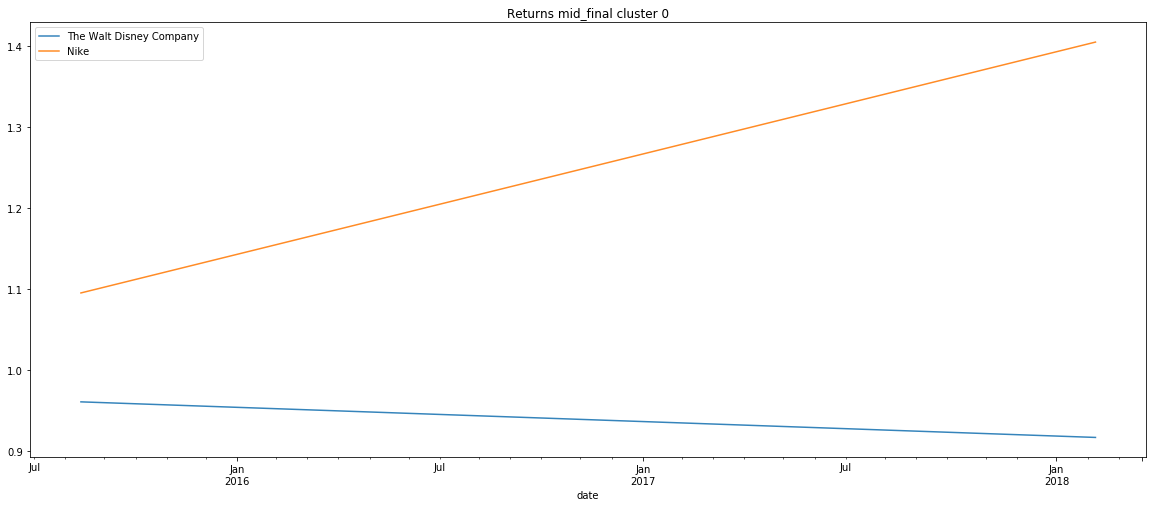

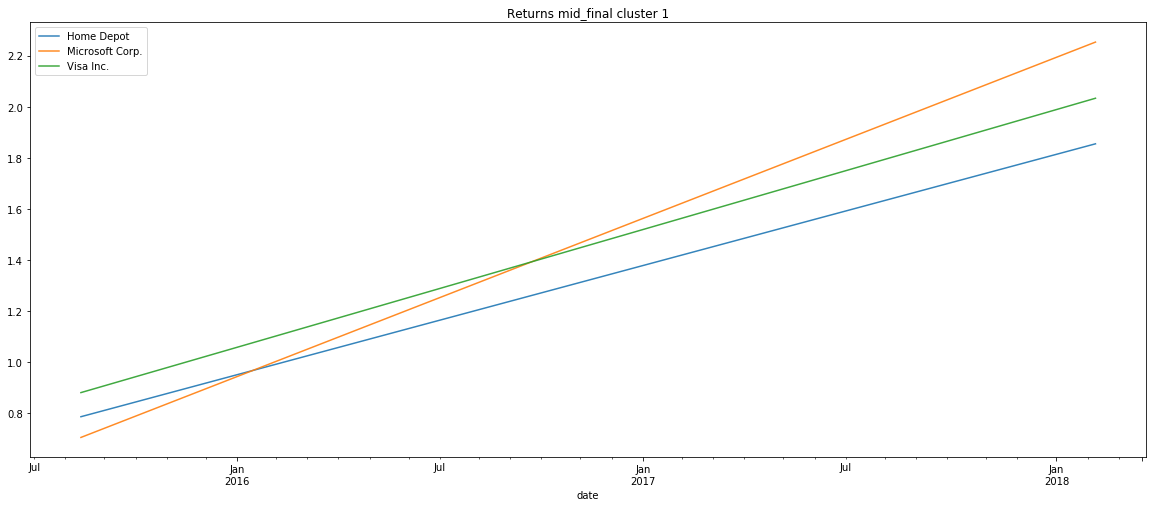

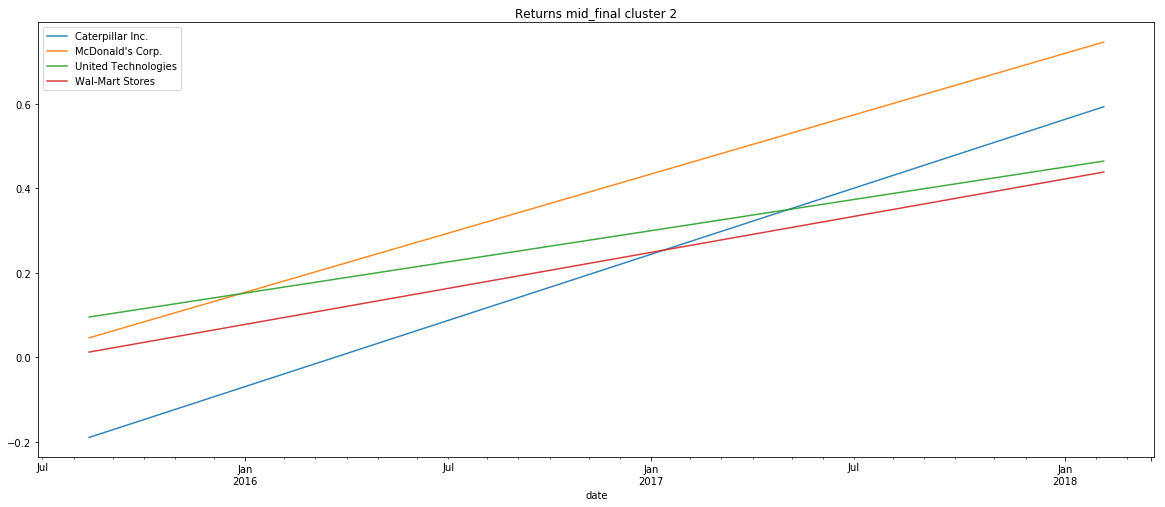

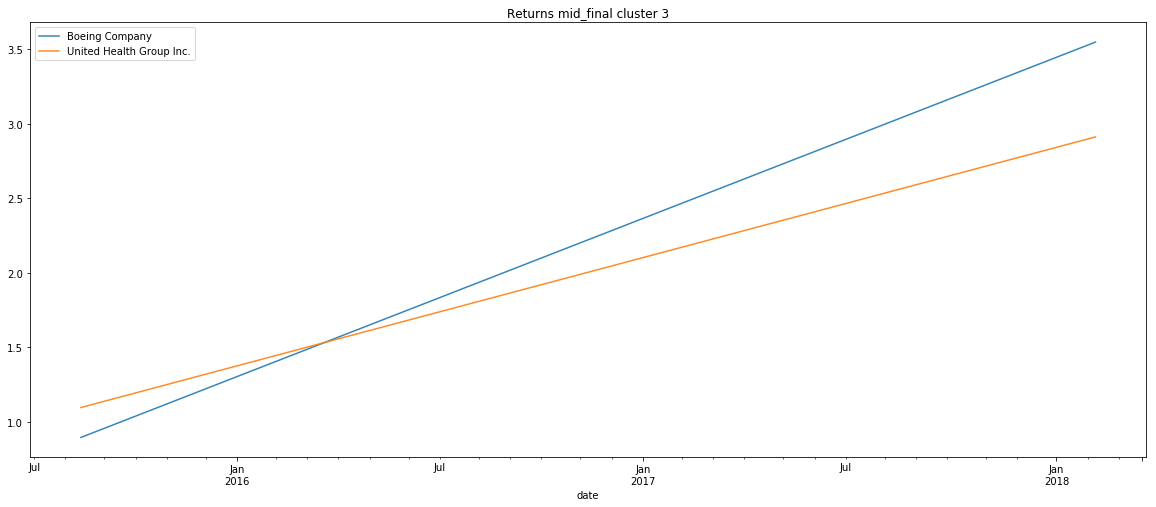

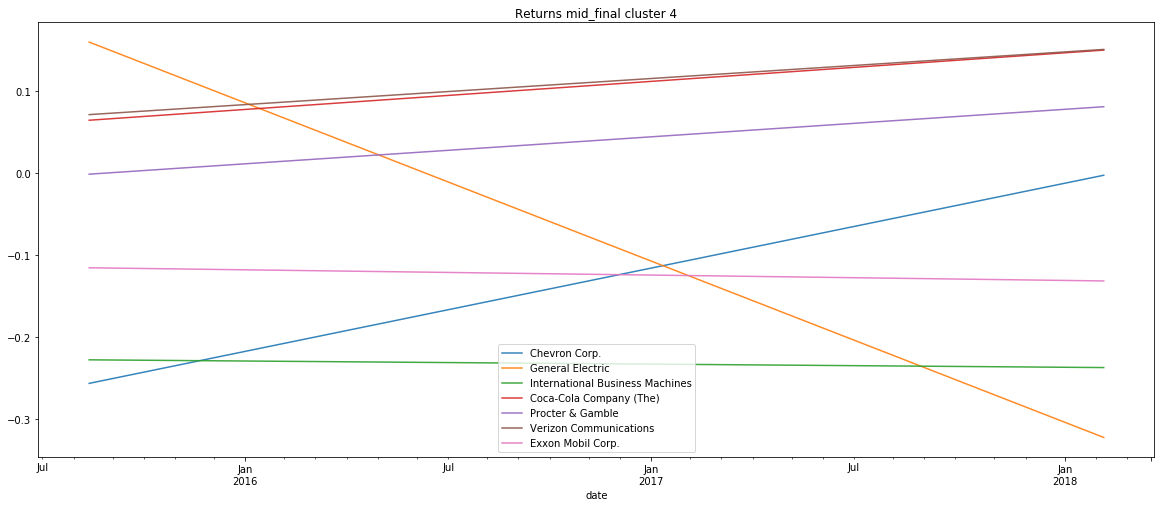

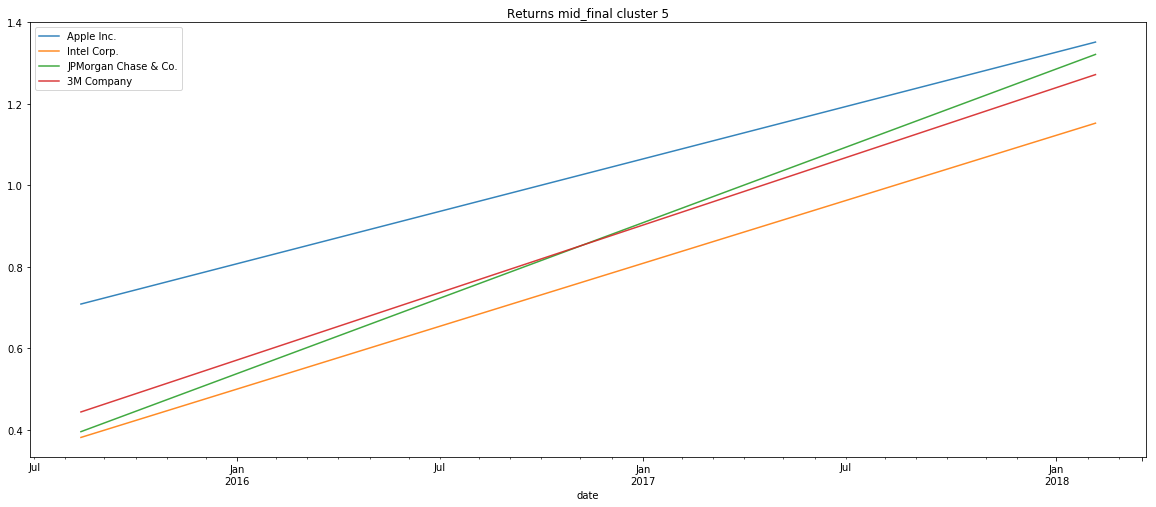

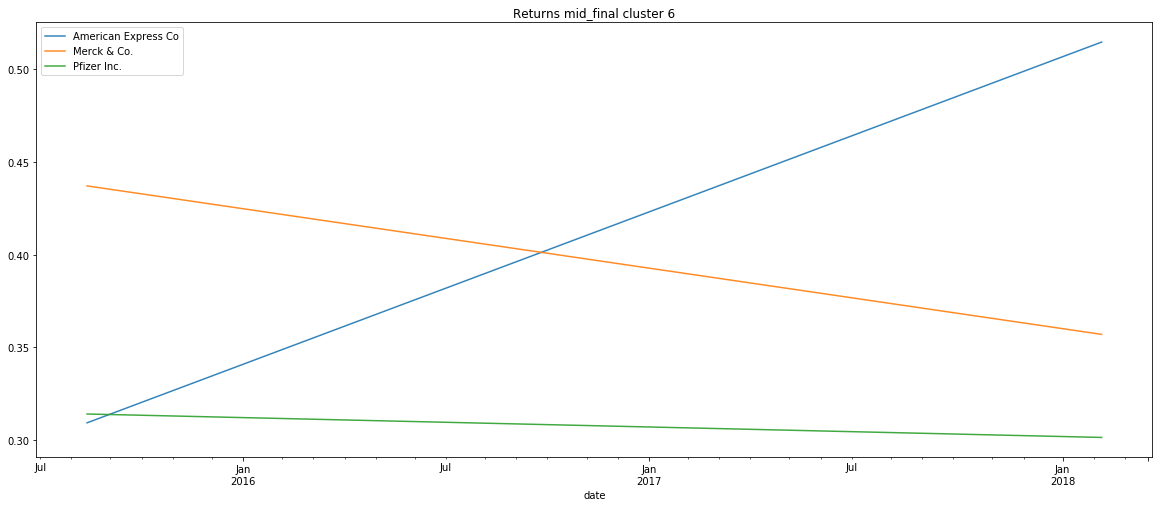

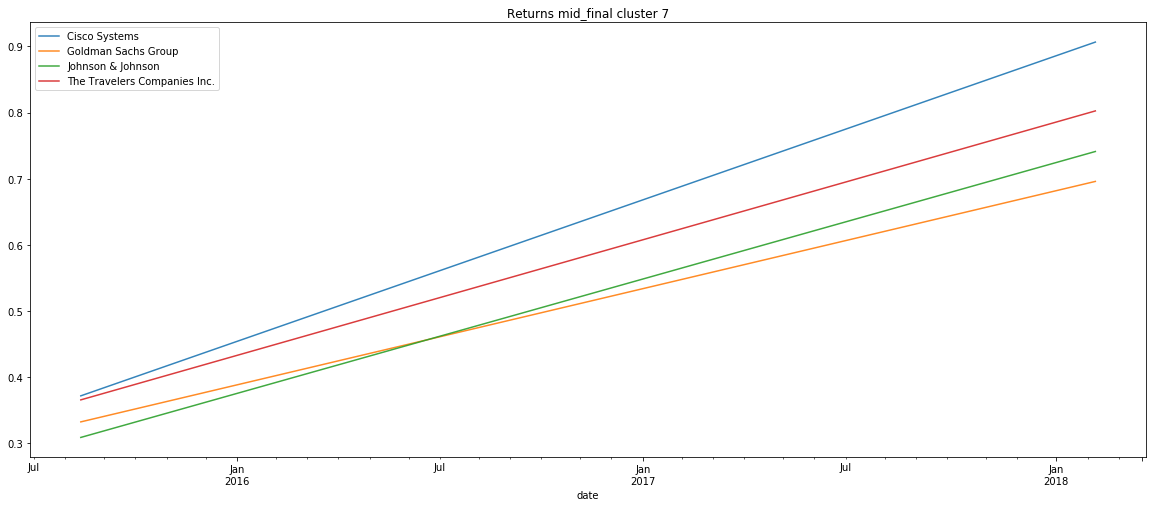

In [42]:
for c in clusters:
    plt.figure(figsize = (20,8))
    for symbol in clusters[c]:
        plot_stock(symbol, stocks=mid_final)
    plt.title('Returns mid_final cluster ' + str(c))
    plt.legend()
    plt.show()

### Plot of the clusters with the mid_final representation - plot the original Dow Jones stock returns

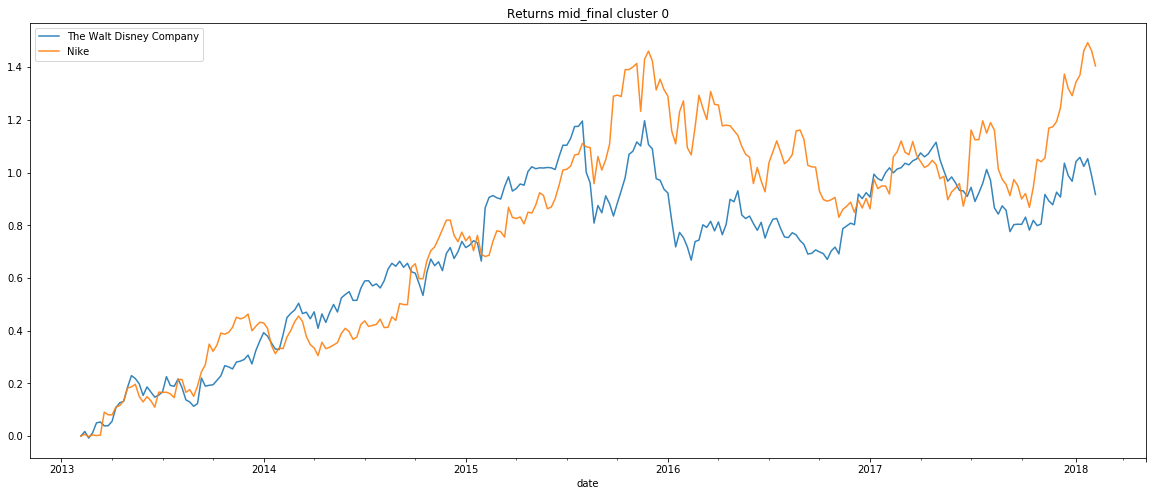

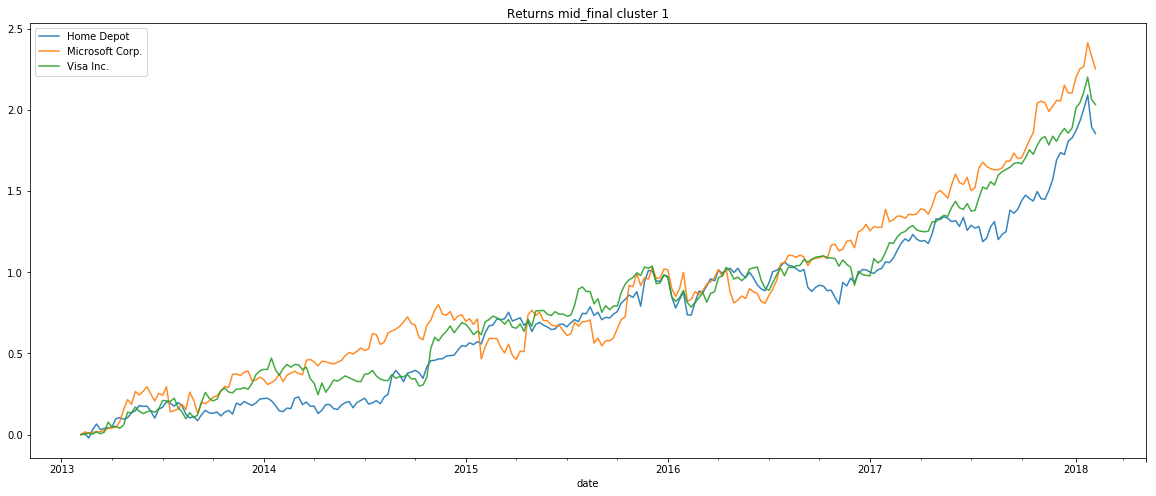

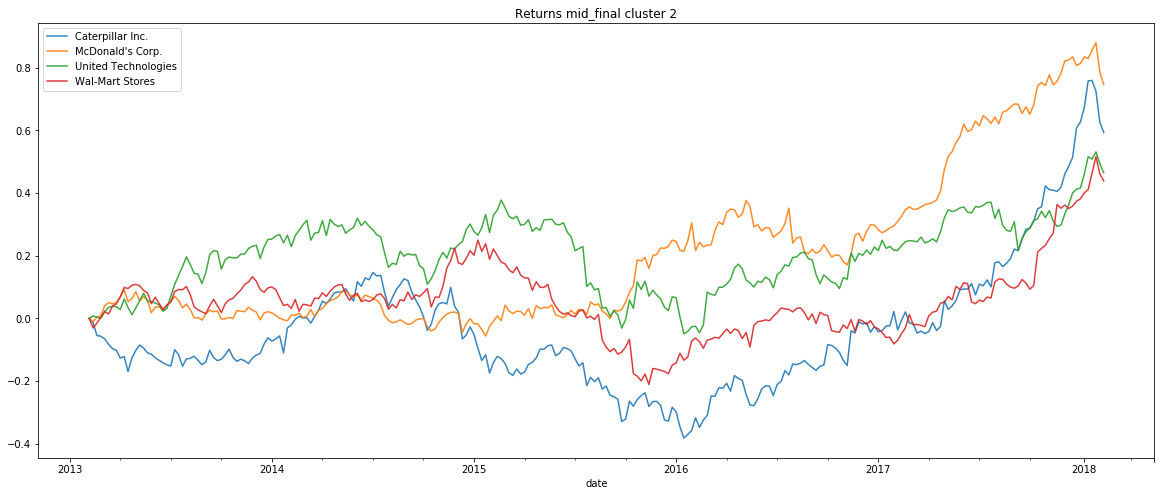

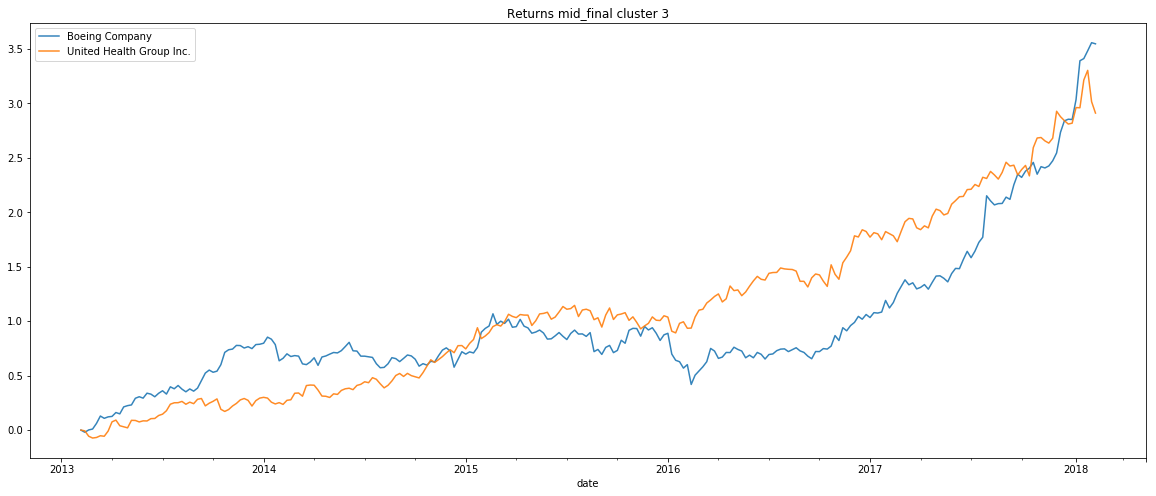

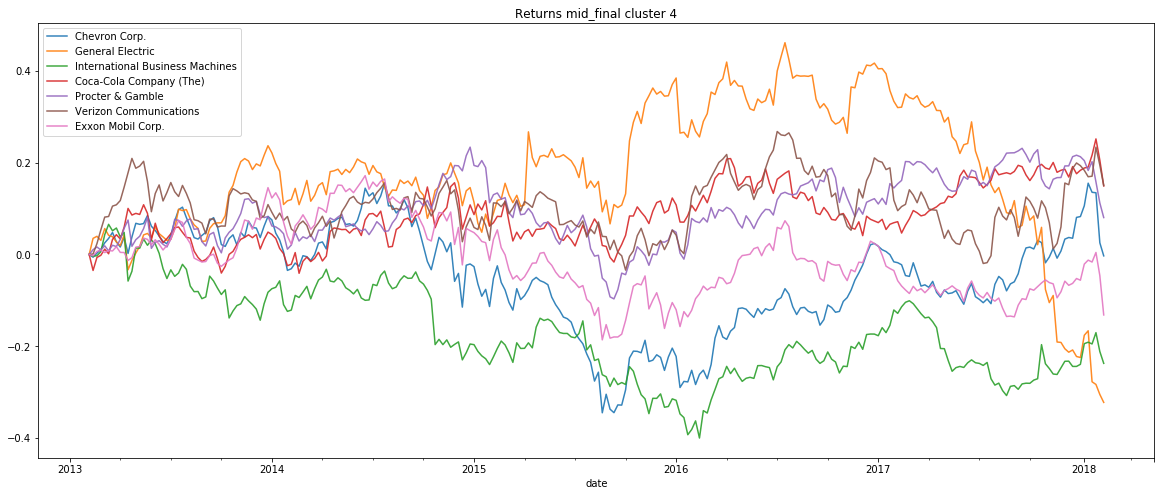

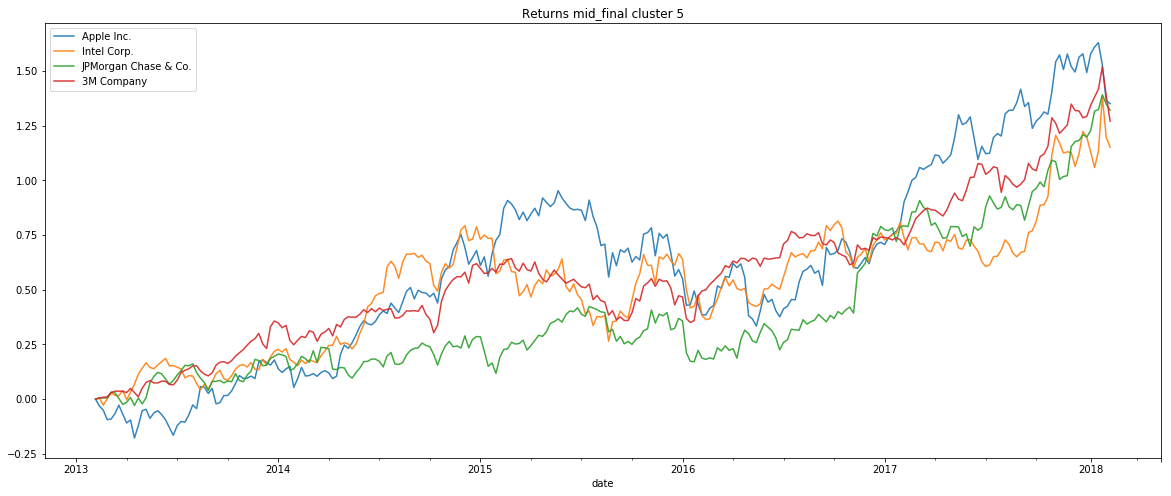

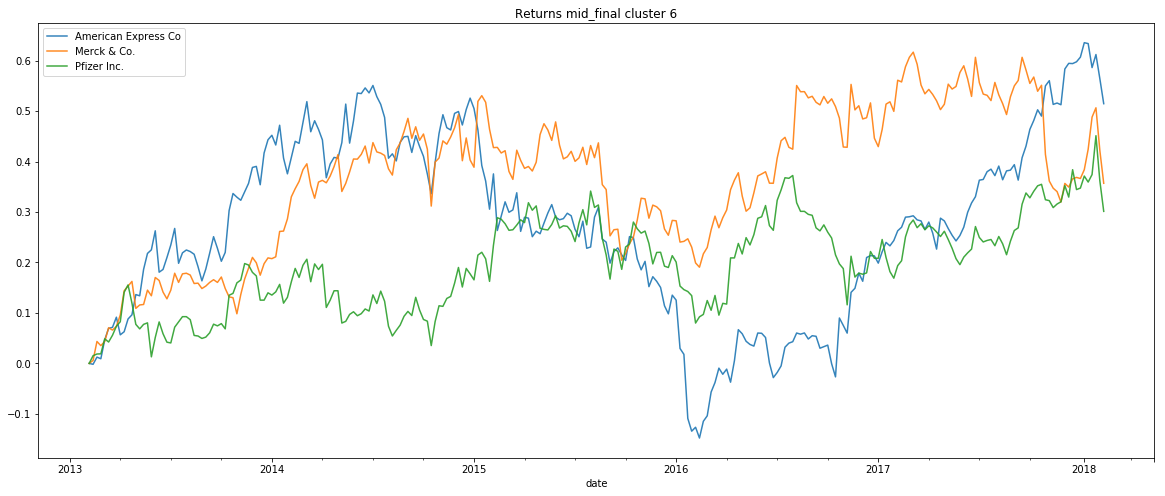

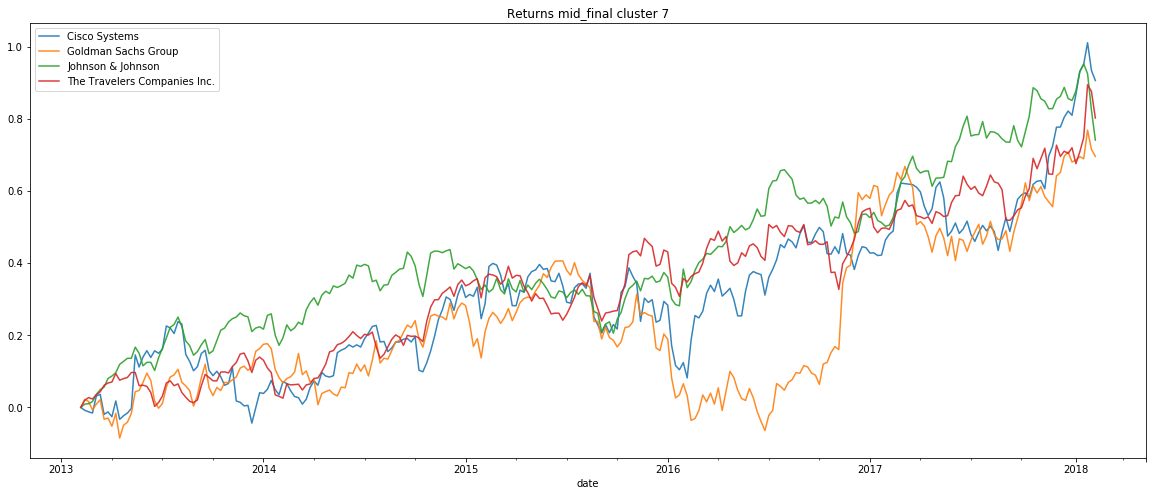

In [43]:
for c in clusters:
    plt.figure(figsize = (20,8))
    for symbol in clusters[c]:
        plot_stock(symbol, stocks=dow_returns)
    plt.title('Returns mid_final cluster ' + str(c))
    plt.legend()
    plt.show()

## If you are looking for a piece of advice ...
### What is performing well, tends to perform well in the future
##### This seemed to be true for Dow Jones stocks in the 2013 - 2018 period. Do your own research

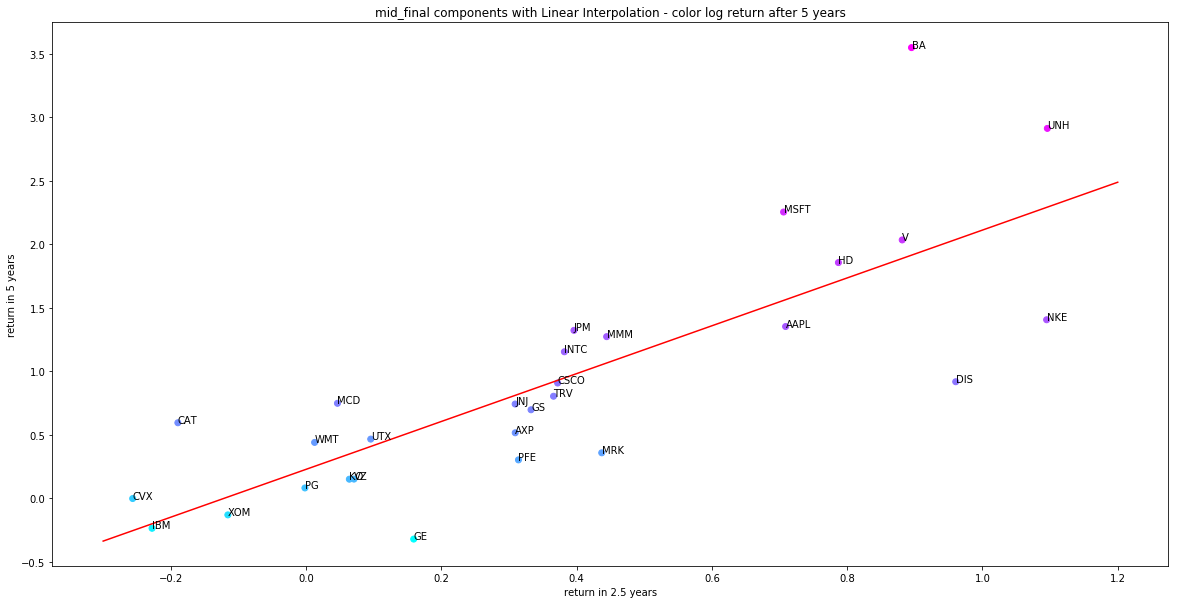

In [44]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(mid_final.T.iloc[:,0].values.reshape(-1,1), mid_final.T.iloc[:,1])
x = np.arange(-0.3, 1.3, 0.1)
y = lr.predict(x.reshape(-1,1))

plt.figure(figsize=(20,10))
plt.scatter(mid_final.T.iloc[:,0], mid_final.T.iloc[:,1], c=mid_final.iloc[-1].T.apply(np.log1p), cmap='cool')
for c in mid_final.columns:
    plt.text(x=mid_final[c].iloc[0], y=mid_final[c].iloc[1], s=c)
plt.plot(x,y,color='red')
plt.xlabel('return in 2.5 years')
plt.ylabel('return in 5 years')
plt.title('mid_final components with Linear Interpolation - color log return after 5 years');

### Another explanation, compatible with this data, is that the stocks that increase their price by 200% ... at certain time, they increased it by 100%

## Disclaimer: past performance is no guarantee of future results

### Except if you happen to have access to a time machine. If you do, buy NVIDIA before you come back from 2013